In [1]:
import sys, importlib
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import BINN
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF

In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

Device set to cpu


In [3]:
path = '../Data/'
file_name = 'cell_density_profiles.npy'

# model options
densities = ['dens_10000', 'dens_12000', 'dens_14000', 
             'dens_16000', 'dens_18000', 'dens_20000']
weight = '_IC1e1_rerun_best_eval'
gamma = 0.2

# variable scaling factors
x_scale = 1/1000 # micrometer -> millimeter
t_scale = 1/24 # hours -> days
u_scale = 1/(x_scale**2) # cells/um^2 -> cells/mm^2

# load data
file = np.load(path + file_name, allow_pickle=True).item()

In [4]:
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

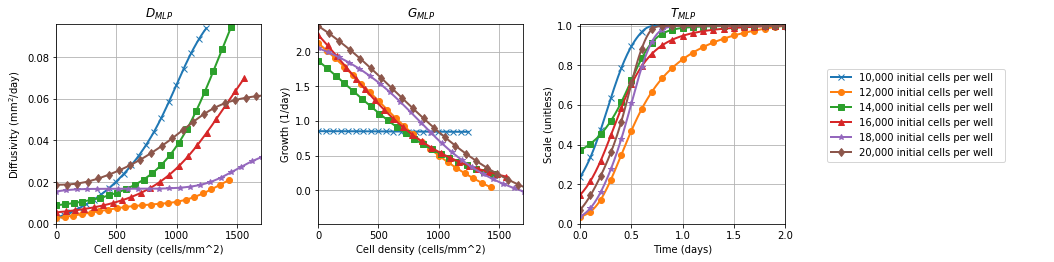

In [5]:
#
# plot parameters for delay-reaction-diffusion binn
#

# minimum and maximum D/G values
dmin = 0.0
dmax = 0.096
gmin = -0.48
gmax = 2.4

# initialize plot
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x','o','s','^','*','d']
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(1, 4, 1)
ax1.set_ylabel(r'Diffusivity (mm$^2$/day)')
ax1.set_xlabel('Cell density (cells/mm^2)')
ax1.set_xlim(0, 1.7e3)
ax1.set_ylim(dmin, dmax)
ax1.set_title(r'$D_{MLP}$')
plt.grid()

ax2 = fig.add_subplot(1, 4, 2)
ax2.set_ylabel('Growth (1/day)')
ax2.set_xlabel('Cell density (cells/mm^2)')
ax2.set_xlim(0, 1.7e3)
ax2.set_ylim(gmin, gmax)
ax2.set_title(r'$G_{MLP}$')
plt.grid()

ax3 = fig.add_subplot(1, 4, 3)
ax3.set_ylabel('Scale (unitless)')
ax3.set_xlabel('Time (days)')
ax3.set_xlim(0, 2)
ax3.set_ylim(0, 1.01)
ax3.set_title(r'$T_{MLP}$')
plt.grid()

ax4 = fig.add_subplot(1, 4, 4)
plt.axis('off')

legend = ['10,000 initial cells per well', '12,000 initial cells per well', '14,000 initial cells per well', 
          '16,000 initial cells per well', '18,000 initial cells per well', '20,000 initial cells per well']

# loop over initial densities
for i, density in enumerate(densities):

    # load data, remove left BC, and rescale
    x = file[density]['x'][1:,0].copy() * x_scale
    t = file[density]['t'][:,0].copy() * t_scale
    X = file[density]['X'][1:,:].copy() * x_scale
    T = file[density]['T'][1:,:].copy() * t_scale
    U = file[density]['U_mean'][1:,:].copy() * u_scale

    # create meshes
    u_mesh = np.linspace(0, 2000, 201)
    u_data = np.linspace(np.min(U), np.max(U), 201)
    t_mesh = np.linspace(0, 2, 201)

    # instantiate BINN
    binn = BINN(delay=True).to(device)

    # wrap model and load weights
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name='../Weights/'+file_name[:-4]+'_'+density[-5:])
    model.save_name += '_' + binn.name + weight
    model.load(model.save_name + '_model', device=device)

    # evaluate parameter networks
    D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
    D_data = to_numpy(binn.diffusion(to_torch(u_data)[:, None]))
    G_mesh = to_numpy(binn.growth(to_torch(u_mesh)[:, None]))
    G_data = to_numpy(binn.growth(to_torch(u_data)[:, None]))
    T1 = to_numpy(binn.delay1(to_torch(t_mesh)[:, None]))
    T2 = to_numpy(binn.delay2(to_torch(t_mesh)[:, None]))

    # rescale time delays and diffusion/growth
    D_mesh *= np.max(T1)
    D_data *= np.max(T1)
    G_mesh *= np.max(T2)
    G_data *= np.max(T2)
    T1 /= np.max(T1)
    T2 /= np.max(T2)

    # update plots
    times = [0,0.5,1.0,1.5,2.0]
    delays = [T1[int(time/len(times)*len(T1))] for time in times]
    ax1.plot(u_data, D_data, '-', linewidth=2, color=colors[i])
    ax2.plot(u_data, G_data, '-', linewidth=2, color=colors[i])
    ax3.plot(t_mesh, T1, '-', linewidth=2, color=colors[i])
    ax1.plot(u_data[::10], D_data[::10], markers[i], color=colors[i])
    ax2.plot(u_data[::10], G_data[::10], markers[i], color=colors[i])
    ax3.plot(t_mesh[::10], T1[::10], markers[i], color=colors[i])

# add legend to 4th subplot
for i in range(len(legend)):
    ax4.plot(u_data, D_data, markers[i]+'-', linewidth=2, color=colors[i])
ax4.set_xlim([-100,-90])
ax4.set_ylim([-100,-90])
ax4.legend(legend, ncol=1, mode='expand', bbox_to_anchor=(-0.1, 0.2, 0.92, 0.6)) # (x, y, width, height))

plt.tight_layout(pad=2)
plt.savefig('../Figures/parameters_delay-reaction-diffusion-binn'+weight+'.pdf', format='pdf')
plt.show()

Dmlp_Gmlp


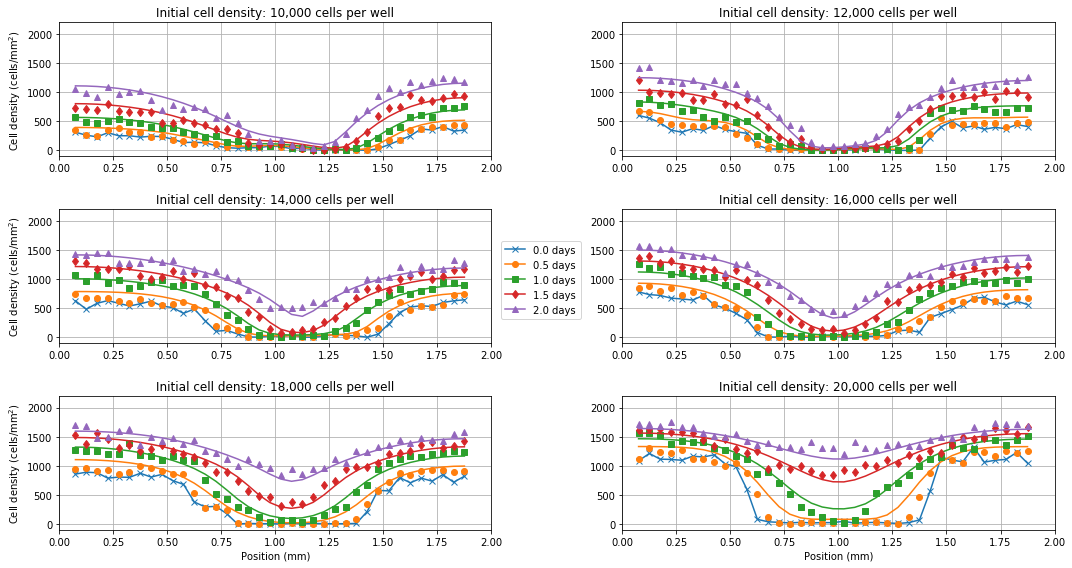


TmlpDmlp_TmlpGmlp


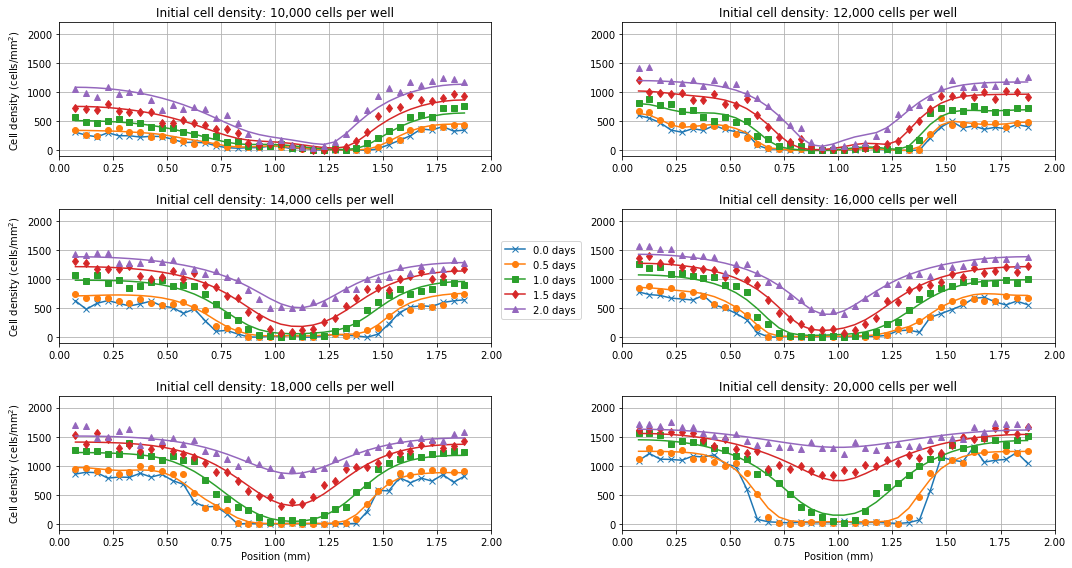

In [6]:
#
# plot PDE forward simulations
#

for delay in [False, True]:
    
    # instantiate BINN
    binn = BINN(delay=delay).to(device)
    parameters = binn.parameters()
    model = ModelWrapper(binn, None, None, save_name='')
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    markers = ['x', 'o', 's', 'd', '^']
    fig = plt.figure(figsize=(15,8))    
    for j, density in enumerate(densities):
        
        # load model weights
        model.save_name = '../Weights/'
        model.save_name += file_name[:-4]+'_'+density[-5:]
        model.save_name += '_' + binn.name + weight
        model.load(model.save_name + '_model', device=device)
        
        # load data
        x = file[density]['x'][1:,0].copy() * x_scale
        t = file[density]['t'][:,0].copy() * t_scale
        X = file[density]['X'][1:,:].copy() * x_scale
        T = file[density]['T'][1:,:].copy() * t_scale
        U = file[density]['U_mean'][1:,:].copy() * u_scale

        # grab initial condition
        u0 = U[:,0].copy()
        
        # learned diffusion term
        def diffusion(u,t):
            if binn.diffusion.inputs == 1:
                D = binn.diffusion(to_torch(u)[:, None])
                s = binn.delay1(to_torch(np.array(t).reshape(1,1)))
                return to_numpy(D*s).reshape(-1)
            else:
                D = binn.diffusion(to_torch(u)[:, None],
                                   to_torch(t*np.ones_like(u))[:, None])
                return to_numpy(D).reshape(-1)

        # learned growth term
        def growth(u,t):
            if binn.growth.inputs == 1:
                r = binn.growth(to_torch(u)[:, None])
                s = binn.delay2(to_torch(np.array(t).reshape(1,1)))
                return to_numpy(r*s).reshape(-1)
            else:
                r = binn.growth(to_torch(u)[:, None],
                                to_torch(t*np.ones_like(u))[:, None])
                return to_numpy(r).reshape(-1)
        
        # simulate PDE
        RHS = PDESolver.PDE_RHS
        u_sim = PDESolver.PDE_sim(RHS, u0, x, t, diffusion, growth)
        
        # compute OLS and GLS errors
        #abs_error = np.mean((u_sim-U)**2)
        #rel_error = np.mean(((u_sim-U)*np.abs(u_sim).clip(1.0,np.inf)**(-gamma))**2)
        #print('{0:6.2f}'.format(rel_error))

        # plot
        ax = fig.add_subplot(3, 2, j+1)
        for i in range(len(X.T)):
            plt.plot(-1, -1, markers[i]+'-', c=colors[i])
        for i in range(len(X.T)):
            plt.plot(X[:,i], U[:,i], marker=markers[i], c=colors[i], linestyle='')
            plt.plot(x, u_sim[:,i], '-', c=colors[i])
        plt.title('Initial cell density: '+density[5:7]+',000 cells per well')
        if j in [4, 5]:
            ax.set_xlabel('Position (mm)')
        if j in [0, 2, 4]:
            ax.set_ylabel(r'Cell density (cells/mm$^2$)')
        if j+1 == 3:
            plt.legend(['0.0 days', '0.5 days', '1.0 days', '1.5 days', '2.0 days'], ncol=1, mode='expand',
                   bbox_to_anchor=(1.01, 0.2, 0.21, 0.6)) # (x, y, width, height)
        plt.ylim(-100, 2200)
        plt.xlim(0, 2)
        plt.grid()
    
    plt.tight_layout(h_pad=2, w_pad=2)
    plt.savefig('../Figures/model_'+binn.name+weight+'.pdf', format='pdf')
    print(binn.name)
    plt.show()
    print()

Dmlp_Gmlp


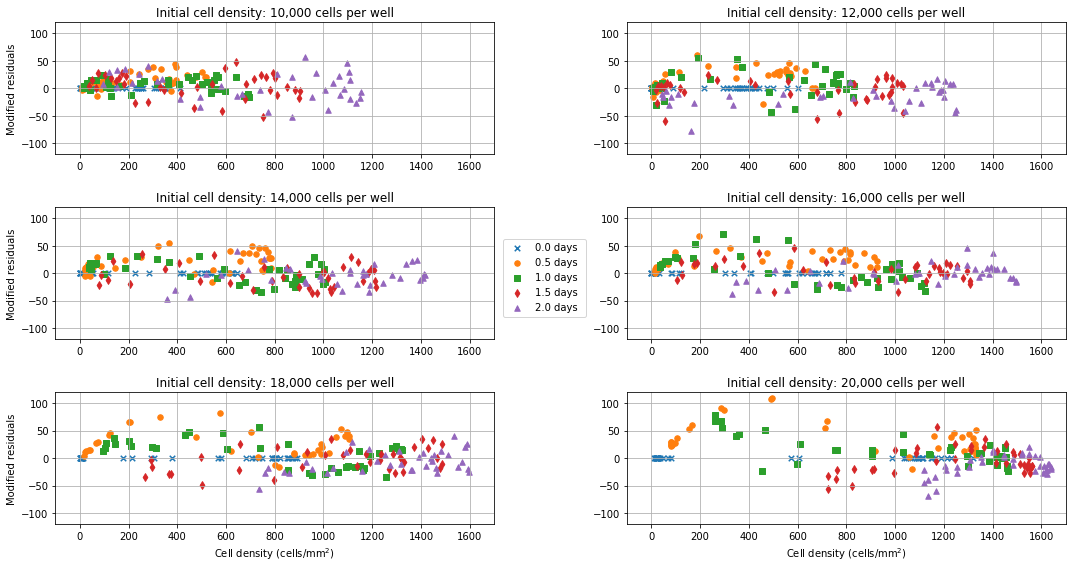


TmlpDmlp_TmlpGmlp


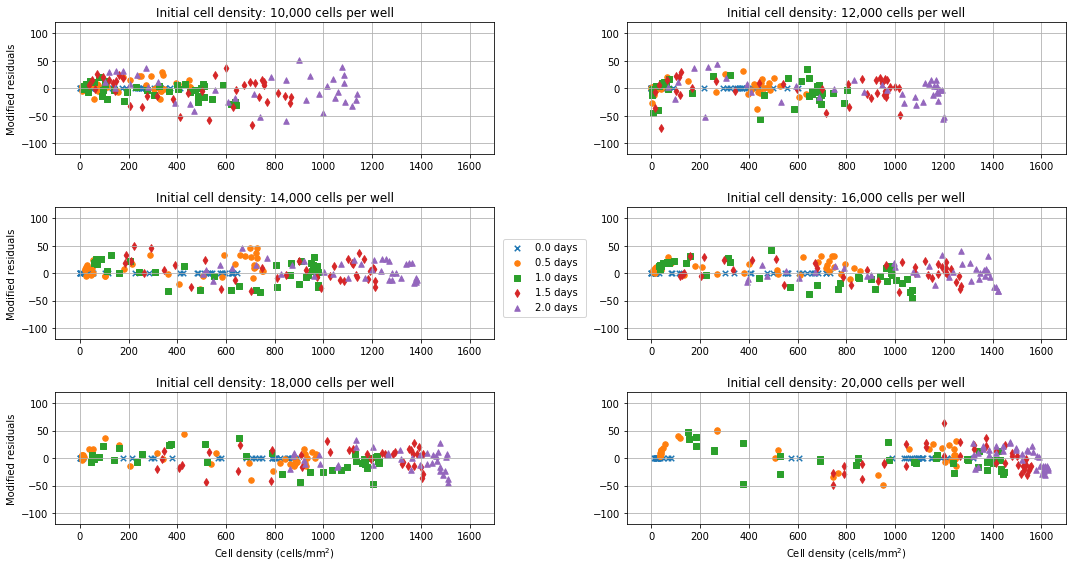

In [7]:
#
# forward modified residuals
#

for delay in [False, True]: 
    
    # instantiate BINN
    binn = BINN(delay=delay).to(device)
    parameters = binn.parameters()
    model = ModelWrapper(binn, None, None, save_name='')
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    markers = ['x', 'o', 's', 'd', '^']
    fig = plt.figure(figsize=(15,8))    
    for j, density in enumerate(densities):
        
        # load model weights
        model.save_name = '../Weights/'
        model.save_name += file_name[:-4]+'_'+density[-5:]
        model.save_name += '_' + binn.name + weight
        model.load(model.save_name + '_model', device=device)
        
        # load data
        x = file[density]['x'][1:,0].copy() * x_scale
        t = file[density]['t'][:,0].copy() * t_scale
        X = file[density]['X'][1:,:].copy() * x_scale
        T = file[density]['T'][1:,:].copy() * t_scale
        U = file[density]['U_mean'][1:,:].copy() * u_scale

        # grab initial condition
        u0 = U[:,0].copy()
        
        # learned diffusion term
        def diffusion(u,t):
            if binn.diffusion.inputs == 1:
                D = binn.diffusion(to_torch(u)[:, None])
                s = binn.delay1(to_torch(np.array(t).reshape(1,1)))
                return to_numpy(D*s).reshape(-1)
            else:
                D = binn.diffusion(to_torch(u)[:, None],
                                   to_torch(t*np.ones_like(u))[:, None])
                return to_numpy(D).reshape(-1)

        # learned growth term
        def growth(u,t):
            if binn.growth.inputs == 1:
                r = binn.growth(to_torch(u)[:, None])
                s = binn.delay2(to_torch(np.array(t).reshape(1,1)))
                return to_numpy(r*s).reshape(-1)
            else:
                r = binn.growth(to_torch(u)[:, None],
                                to_torch(t*np.ones_like(u))[:, None])
                return to_numpy(r).reshape(-1)
        
        # simulate PDE
        RHS = PDESolver.PDE_RHS
        u_sim = PDESolver.PDE_sim(RHS, u0, x, t, diffusion, growth)

        # plot
        ax = fig.add_subplot(3, 2, j+1)
        for i in range(len(X.T)):
            u_pred_scatter = u_sim[:,i]
            u_true_scatter = U[:,i]
            residuals = u_pred_scatter - u_true_scatter
            modified_residuals = residuals * np.abs(u_pred_scatter).clip(1.0, np.inf)**(-gamma)
            plt.scatter(u_pred_scatter, modified_residuals, marker=markers[i], c=colors[i], s=30)
        plt.title('Initial cell density: '+density[5:7]+',000 cells per well')
        if j in [4, 5]:
            ax.set_xlabel(r'Cell density (cells/mm$^2$)')
        if j in [0, 2, 4]:
            ax.set_ylabel(r'Modified residuals')
        if j+1 == 3:
            plt.legend(['0.0 days', '0.5 days', '1.0 days', '1.5 days', '2.0 days'], ncol=1, mode='expand',
                   bbox_to_anchor=(1.01, 0.2, 0.21, 0.6)) # (x, y, width, height)
        plt.ylim(-120, 120)
        plt.xlim(-100, 1700)
        plt.grid()
    
    plt.tight_layout(h_pad=2, w_pad=2)
    plt.savefig('../Figures/residuals_'+binn.name+weight+'.pdf', format='pdf')
    print(binn.name)
    plt.show()
    print()

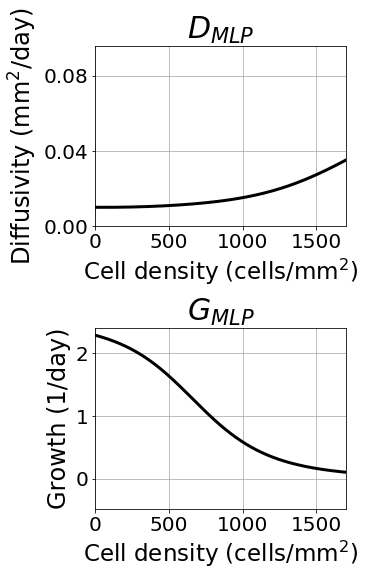

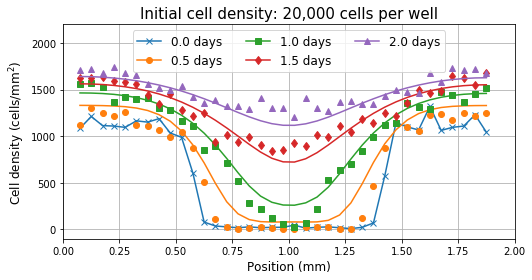

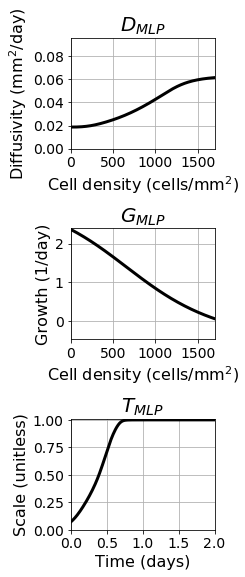

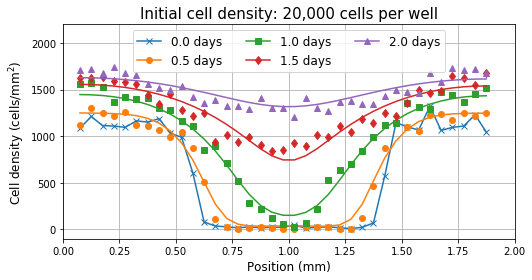

In [8]:
#
# plot model discrepancies
#

# choose initial cell density
density = densities[-1]

for delay in [False, True]:

    # load model
    binn = BINN(delay=delay).to(device)
    parameters = binn.parameters()
    model = ModelWrapper(binn, None, None, save_name='')
    model.save_name = '../Weights/'
    model.save_name += file_name[:-4]+'_'+density[-5:]
    model.save_name += '_' + binn.name + weight
    model.load(model.save_name + '_model', device=device)

    # load data
    x = file[density]['x'][1:,0].copy() * x_scale
    t = file[density]['t'][:,0].copy() * t_scale
    X = file[density]['X'][1:,:].copy() * x_scale
    T = file[density]['T'][1:,:].copy() * t_scale
    U = file[density]['U_mean'][1:,:].copy() * u_scale
    u0 = U[:,0].copy()

    #
    # plot learned parameters
    #

    # evaluate parameters
    u_mesh = np.linspace(np.min(U), np.max(U), 201)
    t_mesh = np.linspace(0, 2, 201)
    D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None])) #* u_scale * t_scale
    G_mesh = to_numpy(binn.growth(to_torch(u_mesh)[:, None])) #* t_scale
    T_mesh = to_numpy(binn.delay1(to_torch(t_mesh)[:, None]))
    D_mesh *= np.max(T_mesh)
    G_mesh *= np.max(T_mesh)
    T_mesh /= np.max(T_mesh)

    # plot
    if delay:
        ticksize = 14
        xlabelsize = 16
        ylabelsize = 16
        titlesize = 20
        fig = plt.figure(figsize=(5*2/3,8))
        ax1 = fig.add_subplot(3, 1, 1)
        plt.xticks(fontsize=ticksize)
        plt.yticks(fontsize=ticksize)
        plt.grid()
        ax2 = fig.add_subplot(3, 1, 2)
        plt.xticks(fontsize=ticksize)
        plt.yticks(fontsize=ticksize)
        plt.grid()
        ax3 = fig.add_subplot(3, 1, 3)
        plt.xticks(fontsize=ticksize)
        plt.yticks(fontsize=ticksize)
        ax3.set_xlabel('Time (days)', fontsize=xlabelsize)
        ax3.set_ylabel('Scale (unitless)', fontsize=ylabelsize)
        ax3.set_xlim(0, 2)
        ax3.set_ylim(0, 1.01)
        ax3.set_title(r'$T_{MLP}$', fontsize=titlesize)
        plt.grid()
    else:
        ticksize = 20
        xlabelsize = 23
        ylabelsize = 24
        titlesize = 30
        fig = plt.figure(figsize=(5,8))
        ax1 = fig.add_subplot(2, 1, 1)
        plt.xticks([0, 500, 1000, 1500], fontsize=ticksize)
        plt.yticks([0, 0.04, 0.08], fontsize=ticksize)
        plt.grid()
        ax2 = fig.add_subplot(2, 1, 2)
        plt.xticks([0, 500, 1000, 1500], fontsize=ticksize)
        plt.yticks([0, 1, 2], fontsize=ticksize)
        plt.grid()
    ax1.set_xlabel(r'Cell density (cells/mm$^2$)', fontsize=xlabelsize)
    ax1.set_ylabel(r'Diffusivity (mm$^2$/day)', fontsize=ylabelsize)
    ax1.set_xlim(0, 1.7e3)
    ax1.set_ylim(model.model.diffusion.min, model.model.diffusion.max)
    ax1.set_title(r'$D_{MLP}$', fontsize=titlesize)
    plt.grid()
    ax2.set_xlabel(r'Cell density (cells/mm$^2$)', fontsize=xlabelsize)
    ax2.set_ylabel('Growth (1/day)', fontsize=ylabelsize)
    ax2.set_xlim(0, 1.7e3)
    ax2.set_ylim(model.model.growth.min, model.model.growth.max)
    ax2.set_title(r'$G_{MLP}$', fontsize=titlesize)
    plt.grid()
    ax1.plot(u_mesh, D_mesh, 'k-', linewidth=3)
    ax2.plot(u_mesh, G_mesh, 'k-', linewidth=3)
    if delay:
        ax3.plot(t_mesh, T_mesh, 'k-', linewidth=3)
    plt.tight_layout()
    plt.savefig('../Figures/discrepancy_parameters_'+binn.name+weight+'.pdf', format='pdf')
    plt.show()

    #
    # plot forward solve
    #

    # learned diffusion term
    def diffusion(u,t):
        if binn.diffusion.inputs == 1:
            D = binn.diffusion(to_torch(u)[:, None])
            s = binn.delay1(to_torch(np.array(t).reshape(1,1)))
            return to_numpy(D*s).reshape(-1)
        else:
            D = binn.diffusion(to_torch(u)[:, None],
                               to_torch(t*np.ones_like(u))[:, None])
            return to_numpy(D).reshape(-1)

    # learned growth term
    def growth(u,t):
        if binn.growth.inputs == 1:
            r = binn.growth(to_torch(u)[:, None])
            s = binn.delay2(to_torch(np.array(t).reshape(1,1)))
            return to_numpy(r*s).reshape(-1)
        else:
            r = binn.growth(to_torch(u)[:, None],
                            to_torch(t*np.ones_like(u))[:, None])
            return to_numpy(r).reshape(-1)

    # simulate PDE
    RHS = PDESolver.PDE_RHS
    u_sim = PDESolver.PDE_sim(RHS, u0, x, t, diffusion, growth)

    # plot pde simulation
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    markers = ['x', 'o', 's', 'd', '^']
    fig = plt.figure(figsize=(7.5,4)) 
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(X.T)):
        plt.plot(-1, -1, markers[i]+'-', c=colors[i])
    for i in range(len(X.T)):
        plt.plot(X[:,i], U[:,i], marker=markers[i], c=colors[i], linestyle='')
        plt.plot(x, u_sim[:,i], '-', c=colors[i])
    rel_error = np.mean(((u_sim-U)*np.abs(u_sim).clip(1.0,np.inf)**(-gamma))**2)
    title = 'Initial cell density: '+density[5:7]+',000 cells per well'
    plt.title(title, fontsize=15)
    ax.set_xlabel('Position (mm)', fontsize=12)
    ax.set_ylabel(r'Cell density (cells/mm$^2$)', fontsize=12)
    plt.legend(['0.0 days', '0.5 days', '1.0 days', '1.5 days', '2.0 days'], 
               fontsize=12, loc='upper center', ncol=3)
    plt.ylim(-100, 2200)
    plt.xlim(0, 2)
    plt.grid()
    plt.tight_layout()
    plt.savefig('../Figures/discrepancy_model_'+binn.name+weight+'.pdf', format='pdf')
    plt.show()

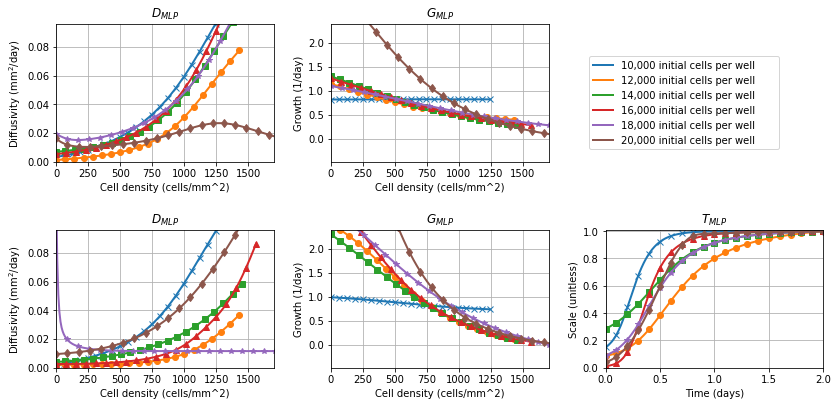

In [9]:
#
# plot unconstrained BINN parameters
#

#
# parameters for reaction-diffusion binn
#

dmin = 0.0
dmax = 0.096
gmin = -0.48
gmax = 2.4

# initialize plot
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x','o','s','^','*','d']
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(2, 3, 1)
ax1.set_ylabel(r'Diffusivity (mm$^2$/day)')
ax1.set_xlabel('Cell density (cells/mm^2)')
ax1.set_xlim(0, 1.7e3)
ax1.set_ylim(dmin, dmax)
ax1.set_title(r'$D_{MLP}$')
plt.grid()

ax2 = fig.add_subplot(2, 3, 2)
ax2.set_ylabel('Growth (1/day)')
ax2.set_xlabel('Cell density (cells/mm^2)')
ax2.set_xlim(0, 1.7e3)
ax2.set_ylim(gmin, gmax)
ax2.set_title(r'$G_{MLP}$')
plt.grid()

ax3 = fig.add_subplot(2, 3, 3)
plt.axis('off')

legend = ['10,000 initial cells per well', '12,000 initial cells per well', '14,000 initial cells per well', 
          '16,000 initial cells per well', '18,000 initial cells per well', '20,000 initial cells per well']

# loop over initial densities
for i, density in enumerate(densities):

    # load data
    x = file[density]['x'][1:,0].copy() * x_scale
    t = file[density]['t'][:,0].copy() * t_scale
    X = file[density]['X'][1:,:].copy() * x_scale
    T = file[density]['T'][1:,:].copy() * t_scale
    U = file[density]['U_mean'][1:,:].copy() * u_scale

    # create meshes
    u_mesh = np.linspace(0, 2000, 201)
    u_data = np.linspace(np.min(U), np.max(U), 201)
    t_mesh = np.linspace(0, 2, 201)

    # compile model
    binn = BINN(delay=False).to(device)
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name='../Weights/'+file_name[:-4]+'_'+density[-5:])
    model.save_name += '_' + binn.name + '_noconstraints_best_val'
    model.load(model.save_name + '_model', device=device)

    # evaluate parameters
    D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
    D_data = to_numpy(binn.diffusion(to_torch(u_data)[:, None]))
    G_mesh = to_numpy(binn.growth(to_torch(u_mesh)[:, None]))
    G_data = to_numpy(binn.growth(to_torch(u_data)[:, None]))
    T1 = to_numpy(binn.delay1(to_torch(t_mesh)[:, None]))
    T2 = to_numpy(binn.delay2(to_torch(t_mesh)[:, None]))

    # rescale time delays and diffusion/growth
    D_mesh *= np.max(T1)
    D_data *= np.max(T1)
    G_mesh *= np.max(T2)
    G_data *= np.max(T2)
    T1 /= np.max(T1)
    T2 /= np.max(T2)

    # update plots
    times = [0,0.5,1.0,1.5,2.0]
    delays = [T1[int(time/len(times)*len(T1))] for time in times]
    ax1.plot(u_data, D_data, '-', linewidth=2, color=colors[i])
    ax2.plot(u_data, G_data, '-', linewidth=2, color=colors[i])
    ax3.plot(t_mesh, T1, '-', linewidth=2, color=colors[i])
    ax1.plot(u_data[::10], D_data[::10], markers[i], color=colors[i])
    ax2.plot(u_data[::10], G_data[::10], markers[i], color=colors[i])

for i in range(len(legend)):
    ax3.plot(u_data, D_data, markers[i]+'-', linewidth=2, color=colors[i])
ax3.set_xlim([-100,-90])
ax3.set_ylim([-100,-90])
ax3.legend(legend, ncol=1, mode='expand', bbox_to_anchor=(-0.1, 0.2, 0.92, 0.6)) # (x, y, width, height))

#
# parameters for delay-reaction-diffusion binn
#

ax1 = fig.add_subplot(2, 3, 4)
ax1.set_ylabel(r'Diffusivity (mm$^2$/day)')
ax1.set_xlabel('Cell density (cells/mm^2)')
ax1.set_xlim(0, 1.7e3)
ax1.set_ylim(dmin, dmax)
ax1.set_title(r'$D_{MLP}$')
plt.grid()

ax2 = fig.add_subplot(2, 3, 5)
ax2.set_ylabel('Growth (1/day)')
ax2.set_xlabel('Cell density (cells/mm^2)')
ax2.set_xlim(0, 1.7e3)
ax2.set_ylim(gmin, gmax)
ax2.set_title(r'$G_{MLP}$')
plt.grid()

ax3 = fig.add_subplot(2, 3, 6)
ax3.set_ylabel('Scale (unitless)')
ax3.set_xlabel('Time (days)')
ax3.set_xlim(0, 2)
ax3.set_ylim(0, 1.01)
ax3.set_title(r'$T_{MLP}$')
plt.grid()

# loop over initial densities
for i, density in enumerate(densities):

    # load data
    x = file[density]['x'][1:,0].copy() * x_scale
    t = file[density]['t'][:,0].copy() * t_scale
    X = file[density]['X'][1:,:].copy() * x_scale
    T = file[density]['T'][1:,:].copy() * t_scale
    U = file[density]['U_mean'][1:,:].copy() * u_scale

    # create meshes
    u_mesh = np.linspace(0, 2000, 201)
    u_data = np.linspace(np.min(U), np.max(U), 201)
    t_mesh = np.linspace(0, 2, 201)

    # compile BINN
    binn = BINN(delay=True).to(device)

    # compile model
    binn = BINN(delay=True).to(device)
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name='../Weights/'+file_name[:-4]+'_'+density[-5:])
    model.save_name += '_' + binn.name + '_noconstraints_best_val'
    model.load(model.save_name + '_model', device=device)

    # evaluate parameters
    D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
    D_data = to_numpy(binn.diffusion(to_torch(u_data)[:, None]))
    G_mesh = to_numpy(binn.growth(to_torch(u_mesh)[:, None]))
    G_data = to_numpy(binn.growth(to_torch(u_data)[:, None]))
    T1 = to_numpy(binn.delay1(to_torch(t_mesh)[:, None]))
    T2 = to_numpy(binn.delay2(to_torch(t_mesh)[:, None]))

    # rescale time delays and diffusion/growth
    D_mesh *= np.max(T1)
    D_data *= np.max(T1)
    G_mesh *= np.max(T2)
    G_data *= np.max(T2)
    T1 /= np.max(T1)
    T2 /= np.max(T2)

    # update plots
    times = [0,0.5,1.0,1.5,2.0]
    delays = [T1[int(time/len(times)*len(T1))] for time in times]
    ax1.plot(u_data, D_data, '-', linewidth=2, color=colors[i])
    ax2.plot(u_data, G_data, '-', linewidth=2, color=colors[i])
    ax3.plot(t_mesh, T1, '-', linewidth=2, color=colors[i])
    ax1.plot(u_data[::10], D_data[::10], markers[i], color=colors[i])
    ax2.plot(u_data[::10], G_data[::10], markers[i], color=colors[i])
    ax3.plot(t_mesh[::10], T1[::10], markers[i], color=colors[i])

plt.tight_layout(pad=2)
plt.savefig('../Figures/parameters_RDBINN_and_DRDBINN'+weight+'.pdf', format='pdf')
plt.show()

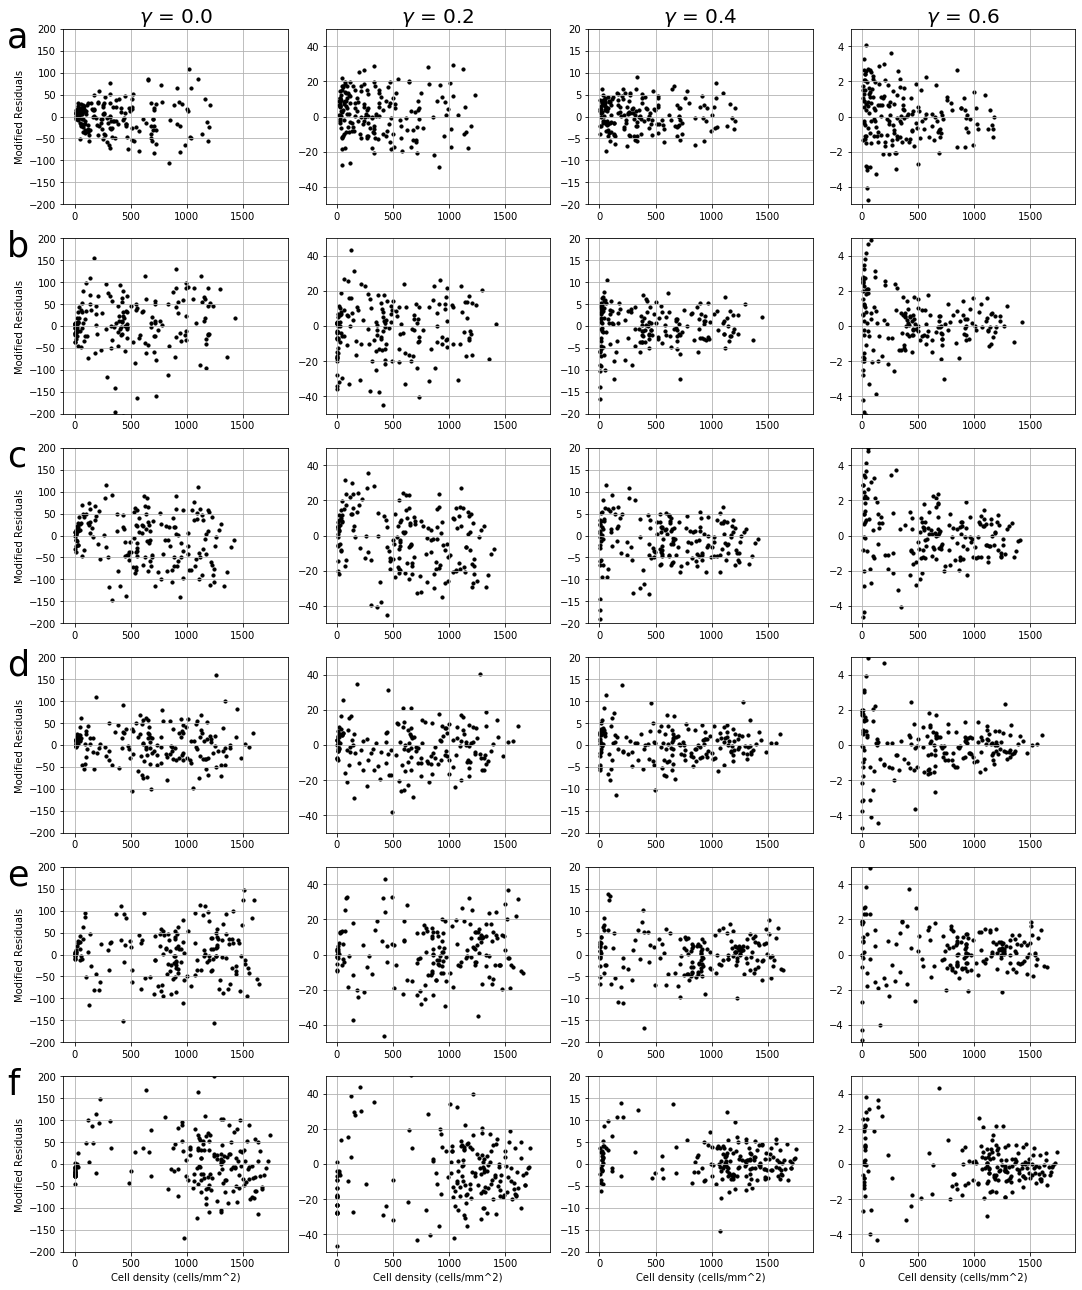

In [10]:
#
# plot residuals
#

from Modules.Models.BuildBINNs import u_MLP

fig = plt.figure(figsize=(15, 18))
count = 1
for density_val in [0, 1, 2, 3, 4, 5]:
    
    #
    # load data
    #
    
    path = '../Data/'
    file_name = 'cell_density_profiles.npy'
    densities = ['dens_10000', 'dens_12000', 'dens_14000', 
                 'dens_16000', 'dens_18000', 'dens_20000']
    # load data
    file = np.load(path + file_name, allow_pickle=True).item()
    density = densities[density_val]
    x = file[density]['x'].copy()[1:,:] 
    t = file[density]['t'].copy()
    X = file[density]['X'].copy()[1:,:]
    T = file[density]['T'].copy()[1:,:]
    U = file[density]['U_mean'].copy()[1:,:]
    shape = U.shape
    
    # variable scales
    x_scale = 1/1000 # micrometer -> millimeter
    t_scale = 1/24 # hours -> days
    u_scale = 1/(x_scale**2) # cells/um^2 -> cells/mm^2
    
    # scale variables
    x *= x_scale
    t *= t_scale
    X *= x_scale
    T *= t_scale
    U *= u_scale
    
    # compute extrema
    x_min, x_max = np.min(x), np.max(x)
    t_min, t_max = np.min(t), np.max(t)
    u_min, u_max = np.min(U), np.max(U)

    # prepare for surface fit
    inputs = np.concatenate([X.reshape(-1)[:, None],
                             T.reshape(-1)[:, None]], axis=1)
    outputs = U.reshape(-1)[:, None]

    # split into train/val
    N = len(inputs)
    split = int(0.8*N)
    p = np.random.permutation(N)
    x_train = inputs[p[:split]]
    y_train = outputs[p[:split]]
    x_val = inputs[p[split:]]
    y_val = outputs[p[split:]]

    # convert to pytorch
    x_train = to_torch(x_train)
    y_train = to_torch(y_train)
    x_val = to_torch(x_val)
    y_val = to_torch(y_val)
    inputs = to_torch(inputs)
    outputs = to_torch(outputs)
    
    #
    # loop over gamma values
    #
    
    for name, gamma in zip(['0p0', '0p2', '0p4', '0p6'], [0.0, 0.2, 0.4, 0.6]):

        # biologically informed neural network
        class BINN(nn.Module):
            def __init__(self):
                super().__init__()
                self.surface_fitter = u_MLP()
            def forward(self, inputs):
                return self.surface_fitter(inputs)
            def surface_loss(self, pred, true):
                residual = (pred - true)**2
                residual *= pred.abs().clamp(min=1.0)**(-gamma)
                return torch.mean(residual)
        binn = BINN().to(device)
        binn.to(device)

        # compile 
        parameters = binn.parameters()
        opt = torch.optim.Adam(parameters, lr=1e-3)
        model = ModelWrapper(
            model=binn,
            optimizer=opt,
            loss=binn.surface_loss,
            save_name='../Weights/'+file_name[:-4]+'_'+density[-5:]+'_gamma_'+name)
        model.load_best_val(device=device)

        #
        # residual plots
        #

        # model prediction
        u_pred = model.predict(inputs.to(device)).cpu().detach().numpy().reshape(-1)
        u_true = U.reshape(-1)
        residuals = u_pred - u_true
        modified_residuals = residuals * np.abs(u_pred).clip(1.0, np.inf)**(-gamma)

        # plot modified residuals
        ax = fig.add_subplot(6, 4, count)
        plt.scatter(u_pred, modified_residuals, color='k', s=10)
        ax.set_xlim(-100, 1900)
        if count < 5:
            ax.set_title(r'$\gamma$ = '+str(gamma), fontsize=20)
        if np.mod(count, 4) == 1:
            ax.set_ylim(-200,200)
            ax.set_ylabel('Modified Residuals')
            ax.text(-0.25, 1.05, ['a','b','c','d','e','f'][density_val], 
                    transform=ax.transAxes, fontsize=35, verticalalignment='top')
        if np.mod(count, 4) == 2:
            ax.set_ylim(-50,50)
        if np.mod(count, 4) == 3:
            ax.set_ylim(-20,20)
        if np.mod(count, 4) == 0:
            ax.set_ylim(-5,5)
        if count > 20:
            ax.set_xlabel('Cell density (cells/mm^2)')
        plt.grid()
        
        count += 1

plt.tight_layout(pad=1)
plt.savefig('../Figures/residuals.pdf', format='pdf')
plt.show()